# Setup

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

# Figure settings
from matplotlib import rcParams
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

# CUDA settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Importing Data

In [2]:
# Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

# Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

# Exploratory Data Analysis

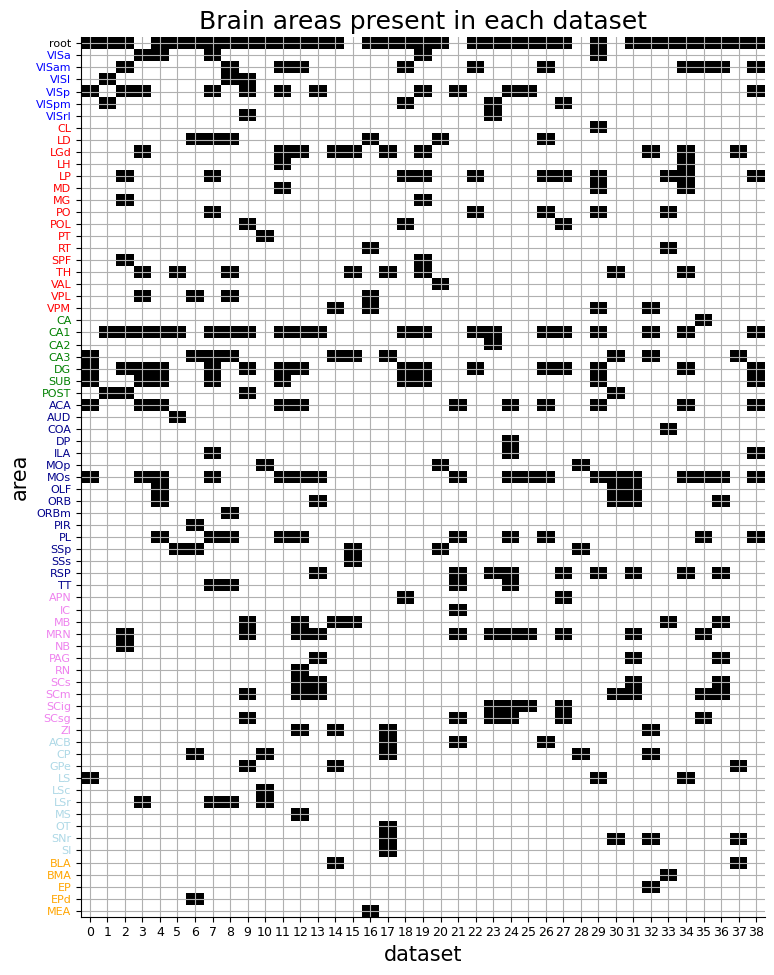

In [3]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

def sort_groups (brain_area):
  for index, group in enumerate(brain_groups):
    for i in group:
      if brain_area == i:
        return regions[index]
  return regions[-1]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

# Pairwise plot of pupil (LHS) and firing rate (RHS)

In [4]:
# Session 12 is selected because of eye-relevant SC (midbrain) and LGd (thalamus) data
session_12 = alldat[12]
data = np.array(session_12['pupil'])

# x-axis values: range of 250 time points * 10ms
x = np.array(range(data.shape[2])) * 10 / 1000

# Constants
dt = 10 / 1000  # convert timebins to seconds
NT = session_12['spks'].shape[-1]
regions_of_interest = ['SCs', 'SCm', 'LGd']

# Get neuron indices for each region of interest
neuron_indices = {region: np.where(session_12['brain_area'] == region)[0] for region in regions_of_interest}

# # Iterate through trials
# for trial in range(session_12['spks'].shape[1]):
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
#     # Pupil plot
#     for dim, label in zip(range(data.shape[0]), ['Pupil size', 'Horizontal pos', 'Vertical pos']):
#         axs[0].plot(x, data[dim, trial, :], label=label)

#     axs[0].legend()
#     axs[0].set_xlabel('Time (s)')
#     axs[0].set_ylabel('Values')
#     axs[0].set_title(f'Trial {trial + 1} - Pupil')

#     # Firing rate plot
#     for region, indices in neuron_indices.items():
#         # Select spikes for neurons in this region and this trial, compute mean spiking rate (in Hz)
#         mean_spiking_rate = session_12['spks'][indices, trial].mean(axis=0) / dt
#         axs[1].plot(np.arange(NT) * dt, mean_spiking_rate, label=region)

#     axs[1].set_xlabel('Time (s)')
#     axs[1].set_ylabel('Mean Spiking Rate (Hz)')
#     axs[1].set_title(f'Trial {trial + 1} - Firing Rate')
#     axs[1].legend()
    
#     plt.tight_layout()
#     plt.show()


# Define RNN

In [5]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, bidi=True):
        super(Net, self).__init__()
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 2, dropout = 0,
                          bidirectional = bidi, nonlinearity = 'tanh')
        self.fc = nn.Linear(ncomp, NN2)
        self.ncomp = ncomp

    def forward(self, x):
        y = self.rnn(x)[0]
        if self.rnn.bidirectional:
            q = (y[:, :, :self.ncomp] + y[:, :, self.ncomp:])/2
        else:
            q = y
        z = F.softplus(self.fc(q), 10)
        # z = self.fc(q)
        return z, q

def Poisson_loss(lam, spk):
    # lam = torch.exp(lam)
    return lam - spk * torch.log(lam + 1e-8)

# Data Preparation

In [11]:
# TODO: PCA across 983 neurons
# TODO: Standardize z-score for y variables -> Neuron-wise normalization
# TODO: Hyperparameter optimization
# TODO: LSTM (?) 
## E.g. Take PCA within SCs, take first 3 PCs -> 3*3 = 9 target variables

(983, 300, 250)

In [6]:
# Constants
regions_of_interest = ['SCs', 'SCm', 'LGd']
num_trials = session_12['spks'].shape[1]
num_timebins = session_12['spks'].shape[2]
num_regions = len(regions_of_interest)

# Initialize arrays for X and y
X = np.zeros((num_trials, 3, num_timebins))  # pupil data
y = np.zeros((num_trials, num_regions, num_timebins))  # average neural activity

# Populate X array with pupil data. X shape is (trial_number, pupil_data_type, timebin)
X[:, 0, :] = session_12['pupil'][0]  # pupil size
X[:, 1, :] = session_12['pupil'][1]  # horizontal position
X[:, 2, :] = session_12['pupil'][2]  # vertical position

# Compute neural firing rates for each region and each trial
for i, region in enumerate(regions_of_interest):
    neuron_indices = np.where(session_12['brain_area'] == region)[0]
    for trial in range(num_trials):
        y[trial, i, :] = session_12['spks'][neuron_indices, trial].mean(axis=0)
        y[trial, i, :] = np.convolve(y[trial, i, :], np.ones(10) / 10, mode='full')[:250]

# Use 80% of data for training and 20% for validation
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors and reshape to match the expected input shape for RNN (seq_len, batch, input_size)
X_train = torch.from_numpy(X_train).permute(2, 0, 1)
y_train = torch.from_numpy(y_train).permute(2, 0, 1)
X_cv = torch.from_numpy(X_cv).permute(2, 0, 1)
y_cv = torch.from_numpy(y_cv).permute(2, 0, 1)

# Training RNN

In [7]:
# Convert data to double precision
X_train = X_train.double()
y_train = y_train.double()
X_cv = X_cv.double()
y_cv = y_cv.double()

# Initialize network
ncomp = 27  # number of hidden units
NN1 = 3  # input size
NN2 = num_regions  # output size
net = Net(ncomp, NN1, NN2)
net = net.double()  # Ensure model parameters are in double precision
wd = 0
lr = 0.001

# Define optimizer and loss function
optimizer = Adam(net.parameters(), weight_decay=wd, lr=lr)
loss_fn = nn.MSELoss()
# loss_fn = nn.PoissonNLLLoss(log_input=False)
# loss_fn = Poisson_loss

# Training loop
niter = 250
for k in range(niter):
    # Forward pass: compute predicted y by passing x to the model
    y_pred, _ = net(X_train)

    # Compute loss
    loss = loss_fn(y_pred, y_train).mean()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    # Perform a single optimization step (parameter update)
    optimizer.step()

    # Zero gradients
    optimizer.zero_grad()

    # Print progress
    if k % 50 == 0:
        print(f'iteration {k}, loss {loss.item():.4f}')


iteration 0, loss 0.0026
iteration 50, loss 0.0004
iteration 100, loss 0.0004
iteration 150, loss 0.0004
iteration 200, loss 0.0004


# Cross Validation

In [8]:
# Initialize variables to store the cross-validation results
cv_losses = []

# Initialize a variable to store the cross-validation predictions
y_cv_pred = []

# Loop over the cross-validation data
for i in range(X_cv.shape[1]):

    # Get the data for the current batch
    x_batch = X_cv[:, i:i+1, :]
    y_batch = y_cv[:, i:i+1, :]

    # Compute the network's output for the current batch
    y_pred, _ = net(x_batch)

    # Compute the loss for the current batch
    loss = loss_fn(y_pred, y_batch).mean()

    # Store the predictions
    y_cv_pred.append(y_pred.detach().numpy())

    # Store the loss
    cv_losses.append(loss.item())

# Compute the average cross-validation loss
cv_loss = np.mean(cv_losses)

print(f'Cross-validation loss: {cv_loss:.4f}')

Cross-validation loss: 0.0004


# Model Performance Summary

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# PyTorch doesn't have a built-in function for summarizing a model like Keras does, but we can create our own summary
print("Model Summary:")
for name, param in net.named_parameters():
    print(f'Layer: {name}  | Size: {param.size()}')

# Training score
train_losses = []

for i in range(X_train.shape[1]):
    x_batch = X_train[:, i:i+1, :]
    y_batch = y_train[:, i:i+1, :]

    y_pred, _ = net(x_batch)
    loss = loss_fn(y_pred, y_batch).mean()

    train_losses.append(loss.item())

train_loss = np.mean(train_losses)

print(f'The model has {count_parameters(net):,} trainable parameters')
print(f'Train loss: {train_loss:.4f}')

# Cross-validation score
print(f'Cross-validation loss: {cv_loss:.4f}')

# TODO: Build better performance summary (look for libraries)

Model Summary:
Layer: rnn.weight_ih_l0  | Size: torch.Size([27, 3])
Layer: rnn.weight_hh_l0  | Size: torch.Size([27, 27])
Layer: rnn.bias_ih_l0  | Size: torch.Size([27])
Layer: rnn.bias_hh_l0  | Size: torch.Size([27])
Layer: rnn.weight_ih_l0_reverse  | Size: torch.Size([27, 3])
Layer: rnn.weight_hh_l0_reverse  | Size: torch.Size([27, 27])
Layer: rnn.bias_ih_l0_reverse  | Size: torch.Size([27])
Layer: rnn.bias_hh_l0_reverse  | Size: torch.Size([27])
Layer: rnn.weight_ih_l1  | Size: torch.Size([27, 54])
Layer: rnn.weight_hh_l1  | Size: torch.Size([27, 27])
Layer: rnn.bias_ih_l1  | Size: torch.Size([27])
Layer: rnn.bias_hh_l1  | Size: torch.Size([27])
Layer: rnn.weight_ih_l1_reverse  | Size: torch.Size([27, 54])
Layer: rnn.weight_hh_l1_reverse  | Size: torch.Size([27, 27])
Layer: rnn.bias_ih_l1_reverse  | Size: torch.Size([27])
Layer: rnn.bias_hh_l1_reverse  | Size: torch.Size([27])
Layer: fc.weight  | Size: torch.Size([3, 27])
Layer: fc.bias  | Size: torch.Size([3])
The model has 6,294 t

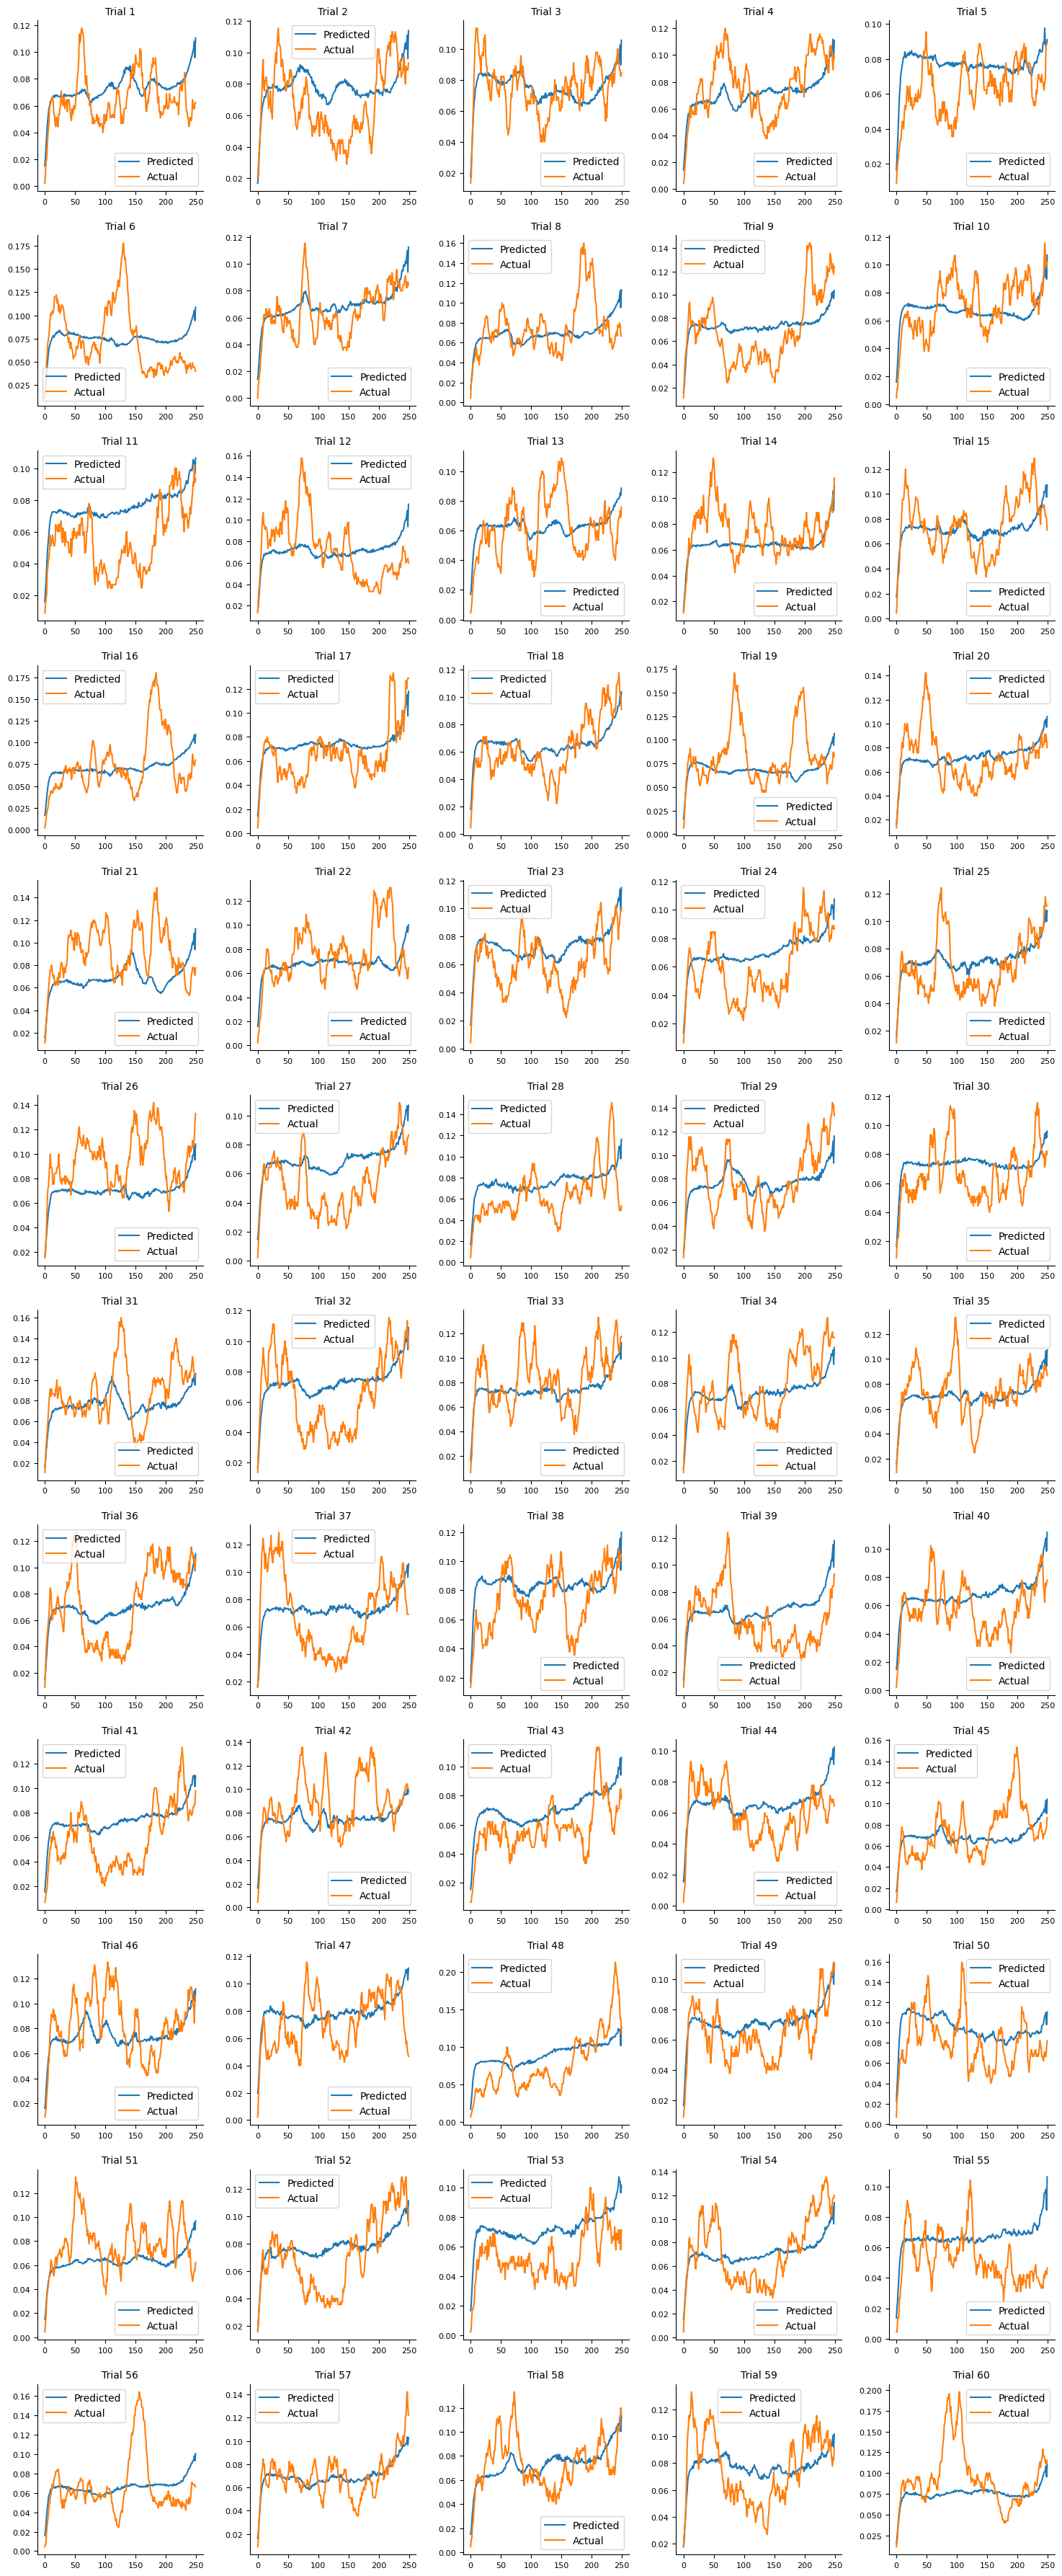

In [12]:
# TODO: Same plots but for train set

# Select data
selection = 1  # 0 for 'SCs', 1 for 'SCm', 2 for 'LGd'

# Select specified data
y_cv_pred = np.array(y_cv_pred)
y_cv_pred_selected = y_cv_pred[..., selection]
y_cv_selected = y_cv[..., selection]

# Permute y_cv_selected to match dimensions of y_cv_pred_selected
y_cv_selected = y_cv_selected.permute(1, 0)

# Calculate number of plots
num_plots = y_cv_selected.shape[0]

# Calculate number of rows needed
num_rows = num_plots // 5 if num_plots % 5 == 0 else num_plots // 5 + 1

# Create subplots for each trial
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))

for i in range(num_plots):
    row = i // 5
    col = i % 5
    axs[row, col].plot(y_cv_pred_selected[i, :], label='Predicted')
    axs[row, col].plot(y_cv_selected[i, :], label='Actual')
    axs[row, col].set_title(f'Trial {i+1}', fontsize=10)
    axs[row, col].legend(fontsize=10)
    axs[row, col].tick_params(axis='both', which='major', labelsize=8)

# Hide any unused subplots
for j in range(num_plots, num_rows * 5):
    axs[j // 5, j % 5].axis('off')

plt.tight_layout()
plt.show()


# Hyperparameter Optimization

In [ ]:
# TODO: Randomized search 
# TODO: Regularization in loss function + early stopping
# Hyperparameters: 
## ncomp, lr, wd, ncomp, num_layers, dropout, bidirectional = bidi, nonlinearity = 'tanh'